In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import close, ioff, ion
from pandas import DataFrame, concat

import numpy as np
from time import time
from os.path import exists, join
from os import mkdir
from numpy import mean, std, sum, min, delete
import pandas as pd
from pandas import read_csv, concat
from sklearn import metrics
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.data import Dataset

from sklearn.model_selection import train_test_split

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

TensorFlow 1.x selected.


In [3]:
N = 24 # Number of WAPS - CONSTANT
MIN_WAPS = 9 # Required number of active WAPS per sample.
NO_SIGNAL_VALUE = -98 # Changed Null Value
QUANTITATIVE_COLUMNS = ['length', 'width'] # Regression Columns
# Used to remove columns where information is missing the validation data.
SAVE_FIGS = False # Trigger to save/overwrite figures(saves 5 seconds if False)
SAVE_REPORT = False # Trigger to save/overwrite report
PRINT_SUB = False # Trigger to print sub reports or not.
DISPLAY_PLOTS = False # If true, the 20 figures will be created on screen.
SRC_NULL = 100 # Original Null Value
DST_NULL = -98 # Changed Null Value
MIN_WAPS = 9 # Minimum number of WAPS per sample.

In [4]:
def load_data(train_fname, N, dst_null=DST_NULL, ):
    data = pd.read_csv(train_fname)
    data = data.reindex(np.random.permutation(data.index))
    del data['pos']
    X = data.iloc[:, :N]
    Y = data.iloc[:, N:]
    X.replace(SRC_NULL, dst_null, inplace=True)
    X[X < dst_null] = dst_null
    X /= min(X)
    X = 1 - X
    return X, Y

data = load_data("train_set.csv",N, dst_null=NO_SIGNAL_VALUE) 
X, Y = data            
X


,CZUST (04_8B_42_23_50_CF),CZUST (06_05_88_E1_E2_02),CZUST (06_05_88_E1_F1_D6),CZUST (06_05_88_E1_F5_F6),CZUST (06_05_88_E1_F5_F7),CZUST (06_05_88_E7_F5_48),fc (EC_41_18_F2_16_5D),fc_5G (EC_41_18_F2_16_5E),feichang (5C_78_F8_2D_D6_38),iSimple (04_D9_F5_FA_DA_B8),iSimpleDev (24_4B_FE_31_38_40),iSimpleDev_5G (24_4B_FE_31_38_44),iSimple_5G (04_D9_F5_FA_DA_BC),Wifi-7628-1522 (3C_8F_06_01_15_22),CZUST (04_8B_42_22_72_E5),ZYTX_AP (AC_1F_09_01_8B_62),CZUST (06_05_88_E1_E9_5E),CZUST (06_05_88_E7_FD_BC),ap_mishare_0f94 (7E_2A_31_66_A0_F3),CZUST (04_8B_42_22_71_F0),CZUST (04_8B_42_23_66_0A),CZUST (06_05_88_E7_FF_94),CZUST (06_05_88_E1_E9_5F),CZUST (06_05_88_E1_EA_3A)
12,0.0,0.3,0.3,0.3,0.3,0.1,0.2,0.2,0.3,0.5,0.4,0.5,0.5,0.1,0.0,0.0,0.2,0.1,0.0,0.1,0.0,0.0,0.0,0.0
3,0.0,0.2,0.2,0.1,0.2,0.0,0.2,0.1,0.1,0.2,0.3,0.2,0.2,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.2,0.3,0.2,0.1,0.0,0.3,0.2,0.3,0.4,0.6,0.3,0.3,0.4,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,0.0,0.2,0.2,0.1,0.1,0.0,0.0,0.1,0.1,0.1,0.3,0.2,0.2,0.2,0.0,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.2,0.2,0.2,0.3,0.0,0.2,0.3,0.3,0.2,0.1,0.1,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.1,0.3,0.2,0.4,0.3,0.2,0.4,0.3,0.4,0.2,0.3,0.2,0.2,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.1,0.2,0.1,0.0,0.0,0.1,0.1,0.0,0.1,0.3,0.1,0.1,0.1,0.1,0.0,0.3,0.2,0.3,0.2,0.1,0.0,0.0,0.0
19,0.0,0.3,0.4,0.4,0.4,0.1,0.2,0.2,0.3,0.6,0.5,0.5,0.5,0.0,0.0,0.0,0.2,0.1,0.0,0.1,0.0,0.0,0.0,0.0
16,0.0,0.4,0.3,0.5,0.4,0.2,0.3,0.2,0.3,0.3,0.6,0.3,0.2,0.1,0.0,0.0,0.2,0.1,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
def load_tdata(train_fname,dst_null=DST_NULL, ):
    data = pd.read_csv(train_fname)
    del data['pos']
    X = data
    X.replace(SRC_NULL, dst_null, inplace=True)
    X[X < dst_null] = dst_null
    X /= min(X)
    X = 1 - X
    return X

tdata = load_tdata("test_set.csv",dst_null=NO_SIGNAL_VALUE) 
Z = tdata  
z_train = Z.values         

In [6]:
x_train_o, x_test_o, y_train, y_test = train_test_split(X.values, Y.values, test_size=0.1, random_state=0)

In [7]:
def filter_out_low_WAPS(data, labels, num_samples=MIN_WAPS):
    drop_rows = list()
    for i, x in enumerate(data):
        count = sum(x != DST_NULL)
        if count < num_samples:
            drop_rows.append(i)
            
    new_data = delete(data, drop_rows, axis=0)
    new_labels = delete(labels, drop_rows, axis=0)
        
    return new_data, new_labels

x_train_o, y_train = filter_out_low_WAPS(x_train_o, y_train, MIN_WAPS)
x_test_o, y_test = filter_out_low_WAPS(x_test_o, y_test, MIN_WAPS)

In [8]:
y_train = DataFrame(y_train, columns=Y.columns)
y_test = DataFrame(y_test, columns=Y.columns)

In [9]:
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.feature_selection import VarianceThreshold
def load_KNN():
    '''
    Loads K-Nearest Neighbor and gives a name for the output files.
    
    Parameters : None
    
    Returns    : model_name :  (str) Name of the model for output file.
                       clf  : (Classifier) Building and Floor Classifier
                       regr : (REgressor) Longitude and Latitude Regressor
    '''
    model_name = "K-Nearest Neighbors"
    regr = KNeighborsRegressor(n_neighbors=1, algorithm='kd_tree',
                                leaf_size=50, p=1)
    
    return model_name,regr
def threshold_variance(x_train, x_test, z_train, thresh):
    '''
    Removes all features with variance below thresh
    
    Parameters : x_train  : (DataFrame) Training Dataset
                 x_test   : (DataFrame) Test Dataset
                 thresh   : (float) the number used to threshold the variance
    
    Returns    : x_train  : (DataFrame) Training Dataset
                 x_test   : (DataFrame) Test Dataset
    '''   
    variance_thresh = VarianceThreshold(thresh)
    x_train = variance_thresh.fit_transform(x_train)
    x_test = variance_thresh.transform(x_test)
    z_train = variance_thresh.transform(z_train)
    
    return x_train, x_test, z_train

model_name, regr = load_KNN()
x_train, x_test, z_train = threshold_variance(x_train_o, x_test_o, z_train, thresh=0.00001)
data_in =  (x_train, x_test, y_train, y_test, z_train)

In [ ]:
# from numpy import sqrt, square, sum

# def localizaion_error(prediction, truth):
#     x, y  = prediction['length'].values, prediction['width'].values
#     x0, y0 = truth['length'].values, truth['width'].values
#     error = sqrt(square(x - x0) + square(y - y0))
#     return error
    

In [10]:
from time import time

In [11]:
def run_model(model_name,regr,data):
    tic_model = time() # Start model performance timer

    x_train, x_test, y_train, y_test , z_train = data # Decompose tuple into datasets
           
    # Regressor
    fit = regr.fit(x_train, y_train[QUANTITATIVE_COLUMNS])
    prediction = fit.predict(z_train)
    regr_prediction = DataFrame(prediction, columns=QUANTITATIVE_COLUMNS)
    
    prediction = regr_prediction
    
    # errors = localizaion_error(prediction, y_test)
    
    print(prediction)

    
    return prediction

In [12]:
knn_prediction = run_model(model_name,regr, data_in)


   length  width
0    14.0    2.2
1     4.0    6.6
2     8.0    4.4
3    10.0    6.6
4     6.0    2.2
5     8.0    2.2
6    10.0    6.6
7     4.0    4.4


In [35]:
length = knn_prediction['length'].values.tolist()
width = knn_prediction['width'].values.tolist()
width

[2.2, 6.6, 4.4, 6.6, 2.2, 2.2, 6.6, 4.4]

In [36]:
length = [390 + i / 2 * 80.5 for i in length]
width = [85 + j / 2.2 * 87.4 for j in width]
width

[172.4, 347.2, 259.8, 347.2, 172.4, 172.4, 347.2, 259.8]

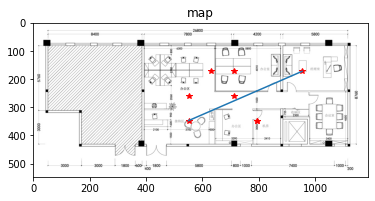

In [40]:
from PIL import Image
from pylab import  *
 
im = array(Image.open('office.jpg'))

imshow(im)
 
x = length
y = width
 
# 使用红色星状物标记绘制点
plot(x,y,'r*')
 
#绘制前两个点的线
plot(x[:2],y[:2])
 
#添加标题，显示绘制的图像
title('map')
show()